# Activation Mapping and Saliency Analysis

This notebook demonstrates the process of generating activation maps and performing saliency analysis on a trained deep learning model for cancer image biomarker detection. The workflow includes:

1. Loading the necessary libraries and dependencies
2. Importing the trained model checkpoint
3. Reconstructing the model architecture (ResNet50)
4. Loading and preprocessing input images
5. Generating activation maps for specific layers
6. Applying saliency methods (e.g., GradCAM) to visualize important regions
7. Analyzing and interpreting the results

Follow the steps below to understand how the model focuses on different parts of medical images to make predictions.

In [19]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from monai.visualize import GuidedBackpropSmoothGrad, blend_images

from fmcib.preprocessing import preprocess

Model Loading and Configuration

This section handles loading the trained model checkpoint and configuring it for analysis:

1. Download the checkpoint from Hugging Face using the command (in the root dir of the repo):
   ```
   huggingface-cli download surajpaib/FMCIB --repo-type model --local-dir .
   ```
2. Load the state dictionary from the downloaded SSL finetuned checkpoint
3. Extract the trunk (feature extractor) and head (classifier) components
4. Configure a MONAI ResNet50 model to match the SSL model architecture
5. Load the trained weights into the MONAI model

This process ensures we have a properly loaded and configured model ready for activation mapping and saliency analysis.

Note: Make sure you have the 'huggingface-cli' installed. If not, you can install it using:

In [8]:
CHECKPOINT_PATH = "../models/baselines/task2/fmcib_finetuned.torch"
state_dict = torch.load(CHECKPOINT_PATH)
trained_trunk = state_dict["trunk_state_dict"]
trained_head = state_dict["head_state_dict"]

trained_trunk.keys(), trained_head.keys()

(odict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.0.bias', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batch

In [9]:
# Get shapes of trained_head keys
for key, value in trained_head.items():
    print(f"{key}: {value.shape}")

0.0.weight: torch.Size([2048, 4096])
0.0.bias: torch.Size([2048])
1.0.weight: torch.Size([512, 2048])
1.0.bias: torch.Size([512])
2.0.weight: torch.Size([256, 512])
2.0.bias: torch.Size([256])
3.0.weight: torch.Size([2, 256])
3.0.bias: torch.Size([2])


In [10]:
# Add trunk of the model
from monai.networks.nets.resnet import ResNet, ResNetBottleneck

trunk = ResNet(
    block=ResNetBottleneck,
    layers=(3, 4, 6, 3),
    block_inplanes=(64, 128, 256, 512),
    spatial_dims=3,
    n_input_channels=1,
    conv1_t_stride=2,
    conv1_t_size=7,
    widen_factor=2,
)
trunk.fc = nn.Identity()

# Add head part of the model
head0 = nn.Sequential(nn.Linear(4096, 2048, bias=True), nn.ReLU(inplace=True))
head1 = nn.Sequential(nn.Linear(2048, 512, bias=True), nn.ReLU(inplace=True))
head2 = nn.Sequential(nn.Linear(512, 256, bias=True), nn.ReLU(inplace=True))
head3 = nn.Sequential(nn.Linear(256, 2, bias=True))
head = nn.Sequential(head0, head1, head2, head3)

In [11]:
trunk.load_state_dict(trained_trunk)
head.load_state_dict(trained_head)
model = nn.Sequential(trunk, head)
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv3d(1, 128, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNetBottleneck(
        (conv1): Conv3d(128, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 512, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
  

Visualize and Preprocess Dataset Images

This section demonstrates how to:
1. Visualize coordinate annotations on the original images
2. Preprocess and crop images for input to the neural network

Key steps:
1. Load the CSV file containing image paths and coordinate annotations
2. Visualize the original image with annotated coordinates
3. Preprocess the image to create the network input

Note: 
- Ensure your CSV file has correct paths to the dataset images
- The CSV should contain columns: image_path, coordX, coordY, coordZ
- You can adapt this for custom datasets by following the same format

For more details on data format and preprocessing, refer to the quick start guide.

In [12]:
df = pd.read_csv("../data/preprocessing/luna16/annotations/task2_test.csv")

In [13]:
df.iloc[0]

Unnamed: 0                                                  263
malignancy                                                    1
coordX                                               -32.199997
coordY                                                 27.34375
coordZ                                                   -169.5
image_path    /mnt/data1/suraj/RadiomicsFoundationModel/LUNA...
Name: 0, dtype: object

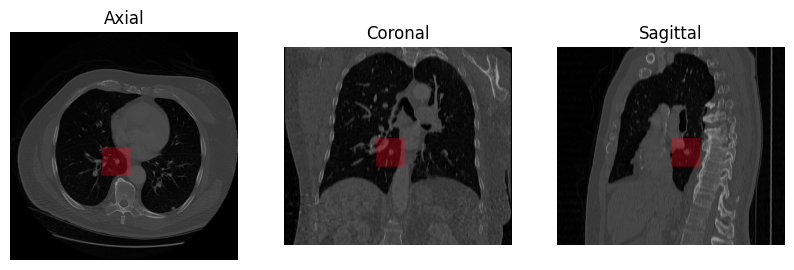

In [14]:
from fmcib.visualization.verify_io import visualize_seed_point

visualize_seed_point(df.iloc[0])  # Visualize annotations on the 0th row.

In [15]:
preprocessed = preprocess(df.iloc[0])

In [16]:
def plot_3d_image(image, cmap=None):
    """
    Plot 3D image slices (axial, coronal, sagittal) at the mid values of each dimension.

    Args:
        image (numpy.ndarray): 3D or 4D image array (single or 3-channel)
    """

    # Handle single channel and 3-channel images
    if image.ndim == 3:
        image = image[np.newaxis, ...]  # Add channel dimension
    elif image.ndim != 4:
        raise ValueError("Image must be 3D or 4D (with channels)")

    # Calculate mid values
    channels, depth, height, width = image.shape
    mid_z, mid_y, mid_x = depth // 2, height // 2, width // 2

    # Function to plot a slice
    def plot_slice(slice_data, title, position):
        plt.subplot(1, 3, position)
        if channels == 1:
            plt.imshow(slice_data[0], cmap=cmap)
        else:
            plt.imshow(np.moveaxis(slice_data, 0, -1))
        plt.title(title)
        plt.axis("off")

    # Plot axial slice
    plot_slice(image[:, mid_z, :, :], "Axial", 1)

    # Plot coronal slice
    plot_slice(np.flipud(image[:, :, mid_y, :]), "Coronal", 2)

    # Plot sagittal slice
    plot_slice(np.flipud(image[:, :, :, mid_x]), "Sagittal", 3)

    plt.tight_layout()
    plt.show()


# Example usage:
# plot_3d_image(image)

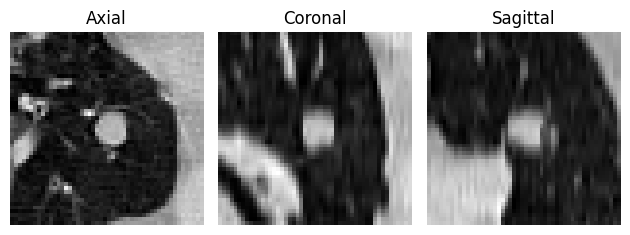

In [17]:
plot_3d_image(preprocessed, cmap="gray")

# Saliency Map Generation and Visualization

This section demonstrates the process of generating and visualizing saliency maps for a 3D medical image using the GuidedBackpropSmoothGrad technique.

The code below implements these steps and provides functions for plotting and displaying the 3D images.

Key components:
- `GuidedBackpropSmoothGrad`: The saliency map generation technique
- `scipy.ndimage.gaussian_filter`: For smoothing the output
- `blend_images`: Custom function to overlay the activation map on the original image
- `plot_3d_image`: Function to display 3D images in axial, coronal, and sagittal views



In [20]:
model = model.to("cuda:0")
activation_model = GuidedBackpropSmoothGrad(model)

Computing GuidedBackpropSmoothGrad:   4%|▍         | 1/25 [00:00<00:16,  1.42it/s]

Computing GuidedBackpropSmoothGrad: 100%|██████████| 25/25 [00:01<00:00, 18.02it/s]
Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


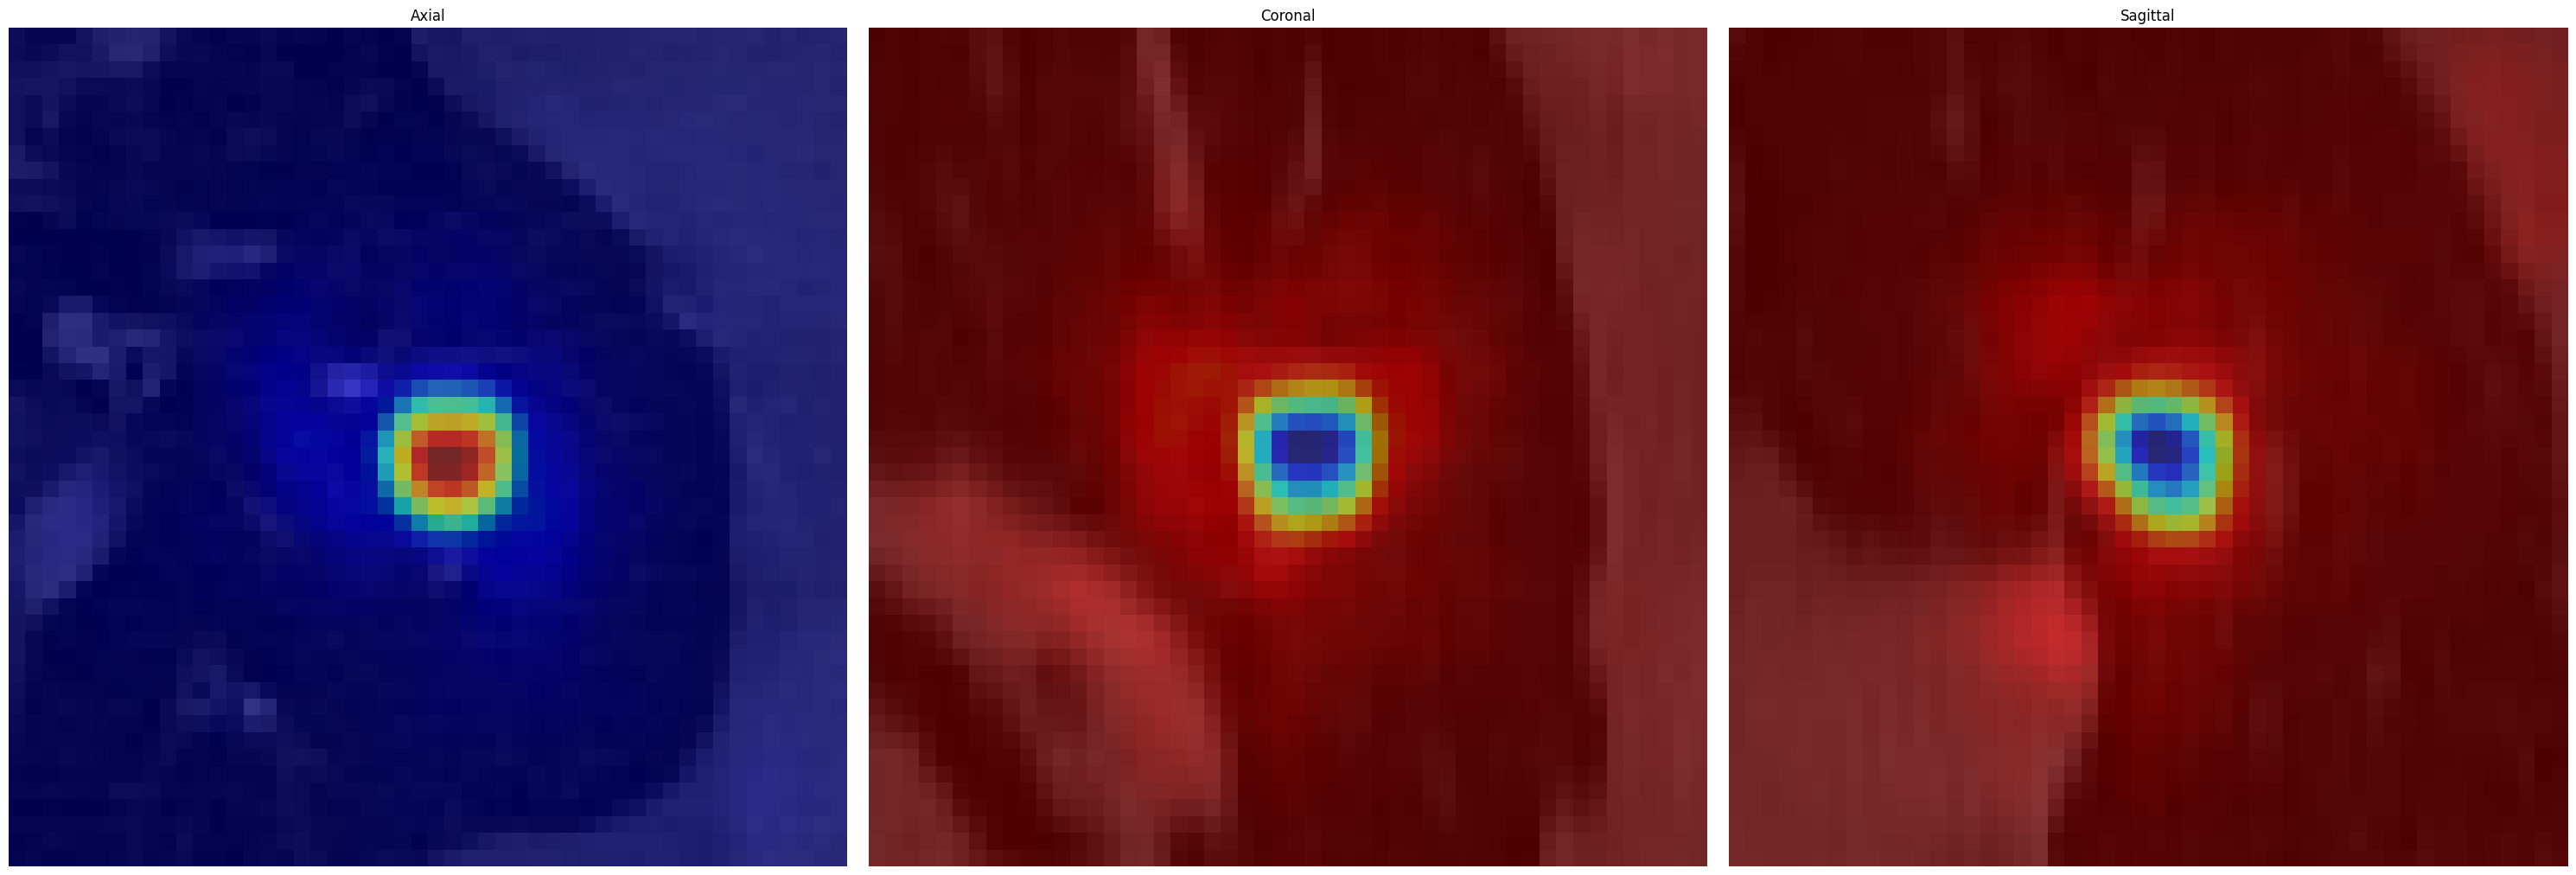

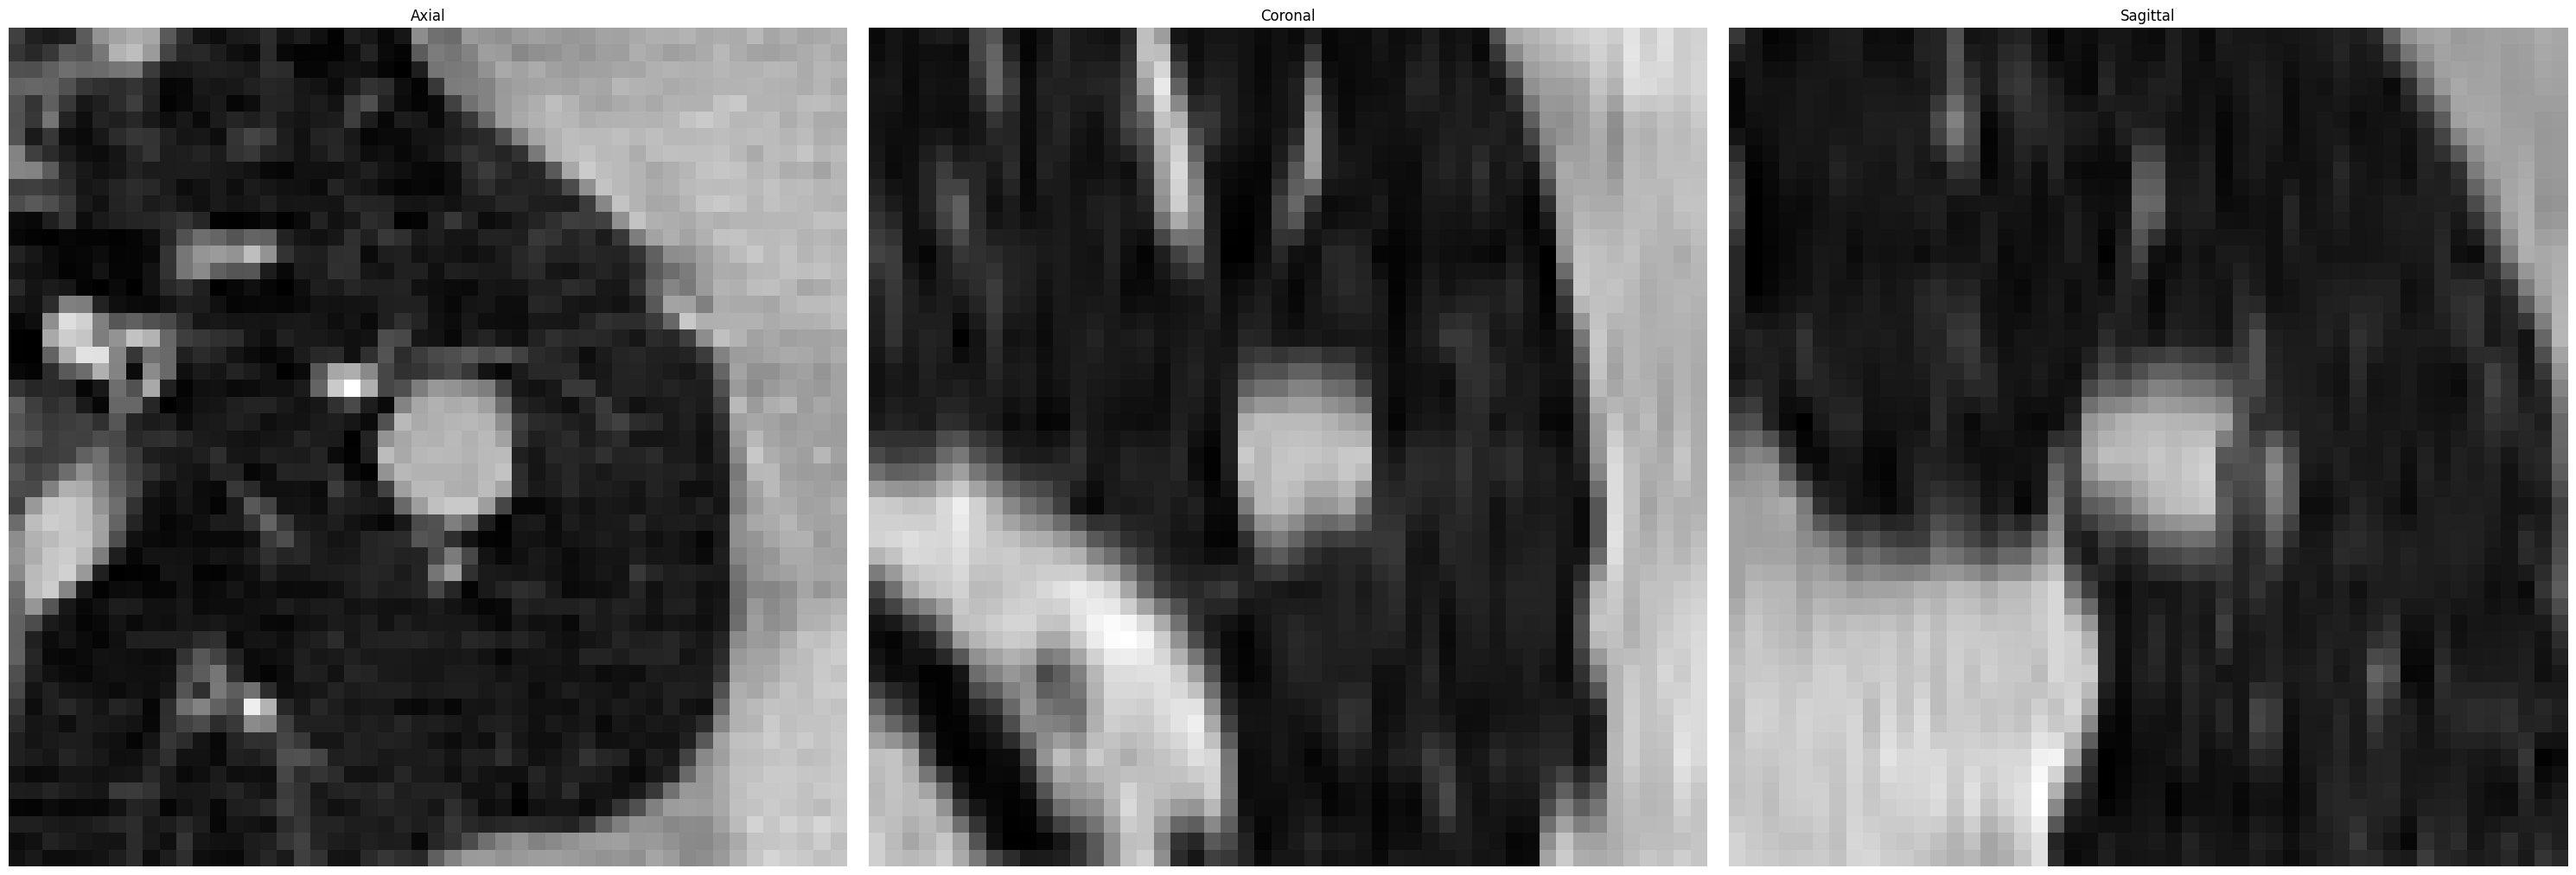

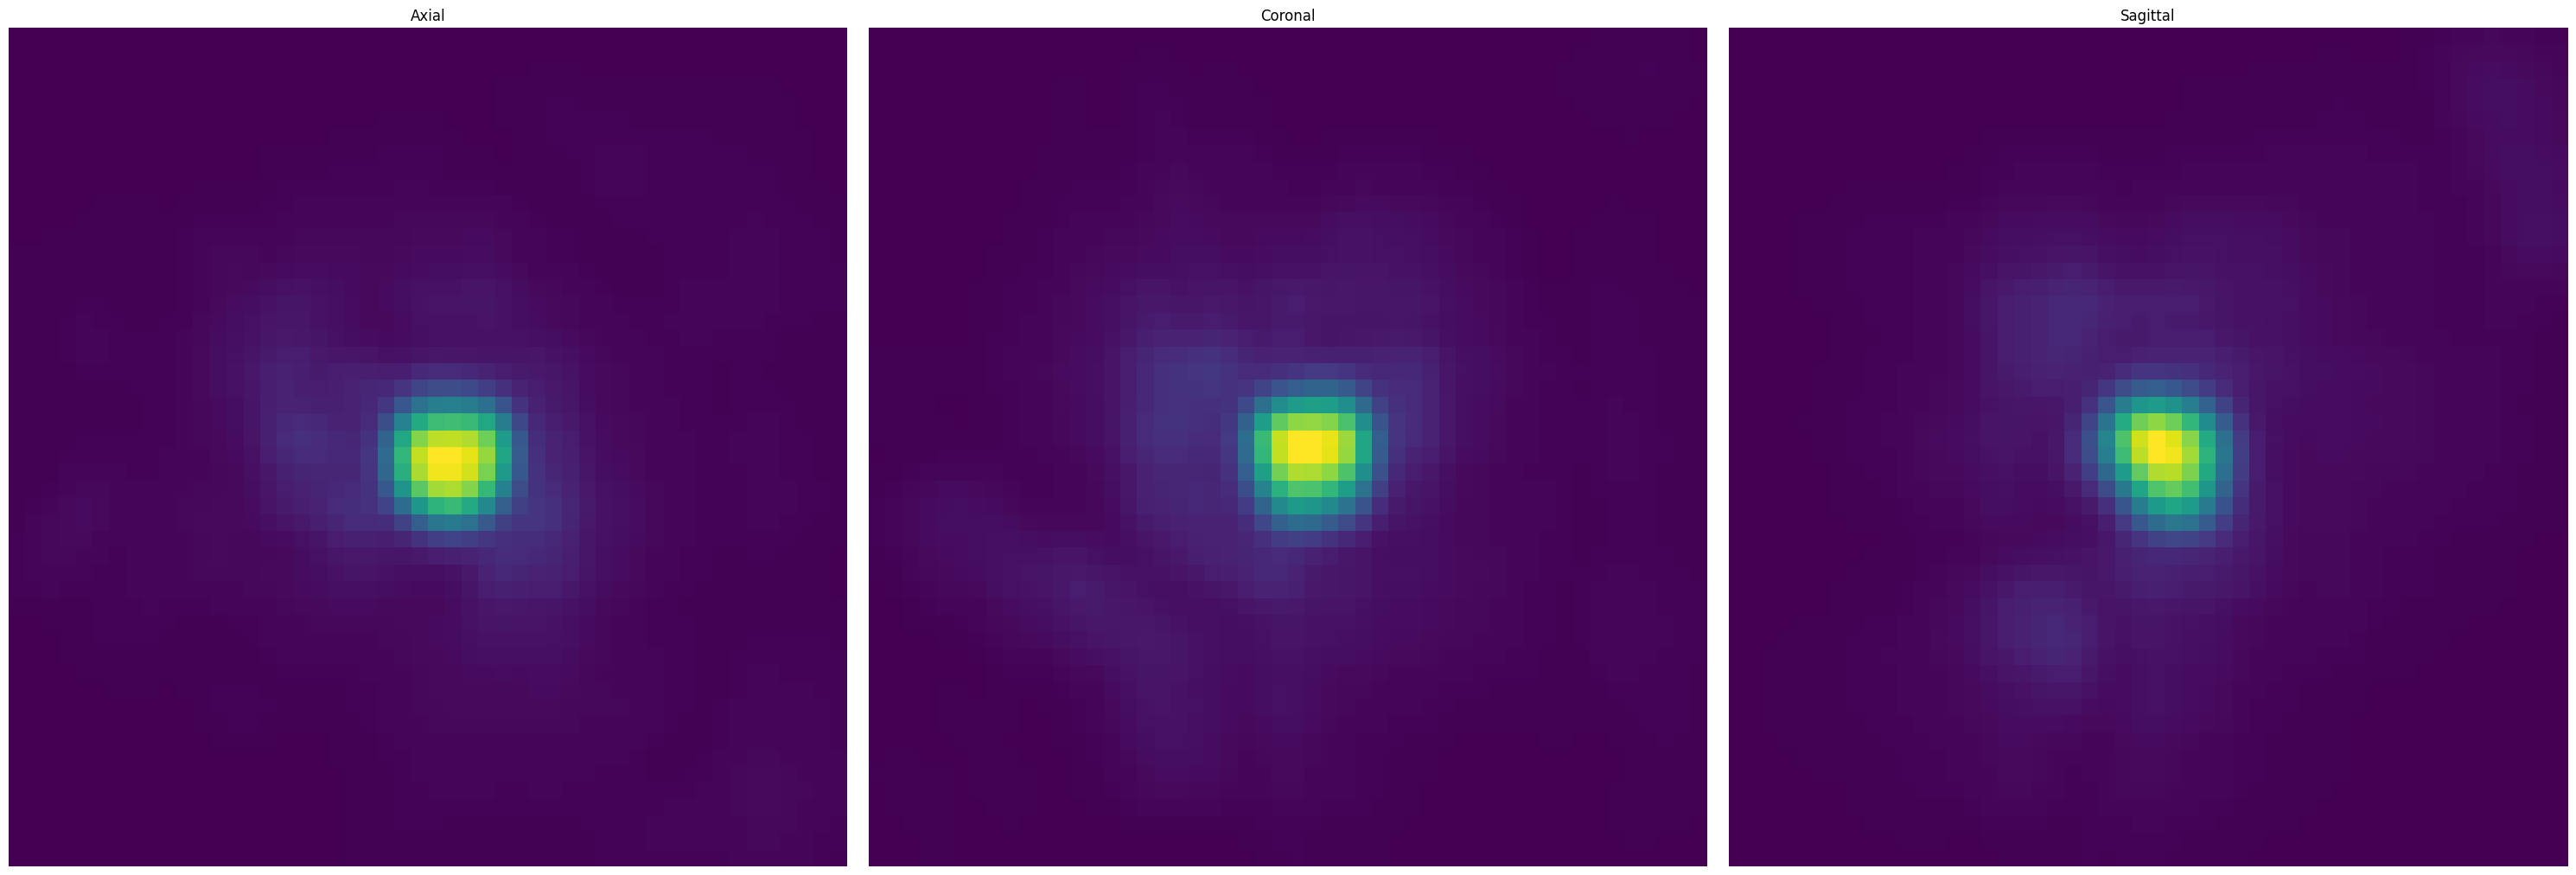

In [21]:
# Process the input data
data = preprocessed.to("cuda").unsqueeze(dim=0)
out = activation_model(data)
data = data.cpu().squeeze().detach().numpy()

# Apply Gaussian smoothing to the output and normalize
smooth_out = scipy.ndimage.gaussian_filter(out.cpu().squeeze().detach().numpy(), sigma=1)
smooth_out = (smooth_out - smooth_out.min()) / (smooth_out.max() - smooth_out.min())

# Blend the original image with the activation map
blended = blend_images(
    torch.from_numpy(data).unsqueeze(0),
    torch.from_numpy(smooth_out).unsqueeze(0),
    alpha=0.6,
    cmap="jet",
    rescale_arrays=False,
    transparent_background=False,
)


# Function to plot and display images
def plot_and_show(image, title, cmap=None):
    plt.figure(figsize=(30, 10))
    plt.title(title)
    plot_3d_image(image, cmap=cmap)
    plt.show()


# Plot blended image, original image, and activation map
plot_and_show(blended.numpy(), "Blended Image")
plot_and_show(data, "Original Image", cmap="gray")
plot_and_show(smooth_out, "Activation Map")